In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import openpyxl

In [3]:
df = pd.read_csv("/content/sample_data/mavik_cafe_sales.csv")

In [4]:
df.shape

(10000, 8)

In [5]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_4271903,Cookie,4,1,ERROR,Credit Card,In-store,19-07-2023
1,TXN_9437049,Cookie,5,1,5,NaN,Takeaway,01-06-2023
2,TXN_5183041,Cookie,5,1,5,Credit Card,In-store,20-04-2023
3,TXN_8927252,UNKNOWN,2,1,ERROR,Credit Card,ERROR,06-11-2023
4,TXN_7710508,UNKNOWN,5,1,5,Cash,NaN,ERROR


In [6]:
print(df.dtypes)

Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object


In [7]:
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

print(df.dtypes)

Transaction ID              object
Item                        object
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method              object
Location                    object
Transaction Date    datetime64[ns]
dtype: object


<ipython-input-7-6ef2f9ada422>:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')


In [8]:
unique_items = df['Item'].unique()

for column in df.columns:
    if column == 'Transaction Date' or column == 'Transaction ID':
        continue
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}':\n{unique_values}\n")


Unique values in column 'Item':
['Cookie' 'UNKNOWN' nan 'ERROR' 'Tea' 'Coffee' 'Cake' 'Juice' 'Smoothie'
 'Sandwich' 'Salad']

Unique values in column 'Quantity':
[ 4.  5.  2. nan  1.  3.]

Unique values in column 'Price Per Unit':
[1.  1.5 2.  3.  4.  5.  nan]

Unique values in column 'Total Spent':
[ nan  5.   2.   1.   3.   4.   7.5  6.   1.5  4.5 10.   8.  12.   9.
 15.  20.  16.  25. ]

Unique values in column 'Payment Method':
['Credit Card' nan 'Cash' 'Digital Wallet' 'ERROR' 'UNKNOWN']

Unique values in column 'Location':
['In-store' 'Takeaway' 'ERROR' nan 'UNKNOWN']



In [9]:

# Replace 'ERROR', 'BLANK', and 'UNKNOWN' with NaN
df.replace(['ERROR', 'BLANK', 'UNKNOWN'], np.nan, inplace=True)

object_columns = df.select_dtypes(include=['object']).count()
float_columns = df.select_dtypes(include=['float64']).count()
datetime_columns = df.select_dtypes(include=['datetime64[ns]']).count()

print("Object columns count:\n", object_columns)
print("\nFloat columns count:\n", float_columns)
print("\nDatetime columns count:\n", datetime_columns)

Object columns count:
 Transaction ID    10000
Item               9031
Payment Method     6822
Location           6039
dtype: int64

Float columns count:
 Quantity          9521
Price Per Unit    9467
Total Spent       9498
dtype: int64

Datetime columns count:
 Transaction Date    9540
dtype: int64


In [10]:
unique_items = df['Item'].unique()
for column in df.columns:
    if column == 'Transaction Date' or column == 'Transaction ID':
        continue  # Skip these columns
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}':\n{unique_values}\n")

Unique values in column 'Item':
['Cookie' nan 'Tea' 'Coffee' 'Cake' 'Juice' 'Smoothie' 'Sandwich' 'Salad']

Unique values in column 'Quantity':
[ 4.  5.  2. nan  1.  3.]

Unique values in column 'Price Per Unit':
[1.  1.5 2.  3.  4.  5.  nan]

Unique values in column 'Total Spent':
[ nan  5.   2.   1.   3.   4.   7.5  6.   1.5  4.5 10.   8.  12.   9.
 15.  20.  16.  25. ]

Unique values in column 'Payment Method':
['Credit Card' nan 'Cash' 'Digital Wallet']

Unique values in column 'Location':
['In-store' 'Takeaway' nan]



In [11]:
missing_values_count = df.isnull().sum()

print(missing_values_count)

Transaction ID         0
Item                 969
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64


In [12]:
item_price_dict = df[['Item', 'Price Per Unit']].dropna().drop_duplicates().set_index('Item')['Price Per Unit'].to_dict()
item_price_df = pd.DataFrame(list(item_price_dict.items()), columns=['Item', 'Price Per Unit'])
print(item_price_df)

       Item  Price Per Unit
0    Cookie             1.0
1       Tea             1.5
2    Coffee             2.0
3      Cake             3.0
4     Juice             3.0
5  Smoothie             4.0
6  Sandwich             4.0
7     Salad             5.0


In [13]:

def fill_missing_values(df, item_price_dict):
    df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Item'].map(item_price_dict))
    df['Item'] = df['Item'].fillna(df['Price Per Unit'].map({v: k for k, v in item_price_dict.items()}))
    df['Price Per Unit'].fillna(df['Total Spent'] / df['Quantity'], inplace=True)
    df['Quantity'].fillna(df['Total Spent'] / df['Price Per Unit'], inplace=True)
    df['Total Spent'].fillna(df['Price Per Unit'] * df['Quantity'], inplace=True)

    return df

df = fill_missing_values(df, item_price_dict)
missing_values_count = df.isnull().sum()

print(missing_values_count)


Transaction ID         0
Item                  54
Quantity              23
Price Per Unit         6
Total Spent           23
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64


<ipython-input-13-318056b62144>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price Per Unit'].fillna(df['Total Spent'] / df['Quantity'], inplace=True)
<ipython-input-13-318056b62144>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [14]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Item'].map(item_price_dict))
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map({v: k for k, v in item_price_dict.items()}))


missing_values_count = df.isnull().sum()

print(missing_values_count)

Transaction ID         0
Item                   6
Quantity              23
Price Per Unit         6
Total Spent           23
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64


In [15]:
df.to_csv('output1.csv', index=False)  # Saves without the index column
df.to_excel('output1.xlsx', index=False)  # Requires openpyxl for `.xlsx` format

In [16]:
# Define the columns to check for NaN values
columns_to_check = [ 'Price Per Unit', 'Quantity', 'Total Spent']


# Keep only rows where there is only one NaN value in the specified columns
df = df.dropna(thresh=len(columns_to_check) - 1, subset=columns_to_check)
print(df)

     Transaction ID    Item  Quantity  Price Per Unit  Total Spent  \
0       TXN_4271903  Cookie       4.0             1.0          4.0   
1       TXN_9437049  Cookie       5.0             1.0          5.0   
2       TXN_5183041  Cookie       5.0             1.0          5.0   
3       TXN_8927252  Cookie       2.0             1.0          2.0   
4       TXN_7710508  Cookie       5.0             1.0          5.0   
...             ...     ...       ...             ...          ...   
9995    TXN_8751702   Juice       5.0             3.0         15.0   
9996    TXN_3809533   Juice       2.0             3.0          6.0   
9997    TXN_5981429   Juice       2.0             3.0          6.0   
9998    TXN_9659401  Cookie       3.0             1.0          3.0   
9999    TXN_7695629  Cookie       3.0             1.0          3.0   

      Payment Method  Location Transaction Date  
0        Credit Card  In-store       2023-07-19  
1                NaN  Takeaway       2023-06-01  
2        

In [17]:
missing_values_count1 = df.isnull().sum()

print(missing_values_count1)

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3168
Location            3952
Transaction Date     460
dtype: int64


In [18]:
print(df.iloc[:, 1:5])

        Item  Quantity  Price Per Unit  Total Spent
0     Cookie       4.0             1.0          4.0
1     Cookie       5.0             1.0          5.0
2     Cookie       5.0             1.0          5.0
3     Cookie       2.0             1.0          2.0
4     Cookie       5.0             1.0          5.0
...      ...       ...             ...          ...
9995   Juice       5.0             3.0         15.0
9996   Juice       2.0             3.0          6.0
9997   Juice       2.0             3.0          6.0
9998  Cookie       3.0             1.0          3.0
9999  Cookie       3.0             1.0          3.0

[9974 rows x 4 columns]


In [19]:
df.to_csv('output.csv', index=False)  # Saves without the index column
df.to_excel('output.xlsx', index=False)  # Requires openpyxl for `.xlsx` format
transaction_row = df[df['Transaction ID'] == 'TXN_1208561']
transaction_row1 = df[df['Transaction ID'] == 'TXN_8751702']
print(transaction_row)
print(transaction_row1)

Empty DataFrame
Columns: [Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, Transaction Date]
Index: []
     Transaction ID   Item  Quantity  Price Per Unit  Total Spent  \
9995    TXN_8751702  Juice       5.0             3.0         15.0   

     Payment Method Location Transaction Date  
9995           Cash      NaN       2023-02-13  


In [20]:
df.shape

(9974, 8)

In [21]:
na_values_count = df.iloc[:, 1:5].isnull().sum()
print(na_values_count)


Item              0
Quantity          0
Price Per Unit    0
Total Spent       0
dtype: int64


In [22]:
df.drop(columns=['Payment Method', 'Location'], inplace=True)



In [23]:
def find_outliers_iqr(df, column):
    # Ensure the column is numeric
    if not pd.api.types.is_numeric_dtype(df[column]):
        print(f"Skipping non-numeric column: {column}")
        return pd.DataFrame()  # Return an empty DataFrame for non-numeric columns

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Apply to numeric columns except 'Price Per Unit'
for col in df.select_dtypes(include=['float64']).columns:
    if col == 'Price Per Unit':
        continue
    outliers = find_outliers_iqr(df, col)
    if not outliers.empty:
        print(f"Outliers in column '{col}':\n{outliers}\n")


Outliers in column 'Total Spent':
     Transaction ID   Item  Quantity  Price Per Unit  Total Spent  \
8264    TXN_2548360  Salad       5.0             5.0         25.0   
8268    TXN_6342161  Salad       5.0             5.0         25.0   
8269    TXN_8914892  Salad       5.0             5.0         25.0   
8276    TXN_5220895  Salad       5.0             5.0         25.0   
8277    TXN_9517146  Salad       5.0             5.0         25.0   
...             ...    ...       ...             ...          ...   
9875    TXN_6378158  Salad       5.0             5.0         25.0   
9894    TXN_6549132  Salad       5.0             5.0         25.0   
9901    TXN_4612269  Salad       5.0             5.0         25.0   
9957    TXN_8872984  Salad       5.0             5.0         25.0   
9978    TXN_3863625  Salad       5.0             5.0         25.0   

     Transaction Date  
8264       2023-11-07  
8268       2023-01-08  
8269       2023-03-15  
8276       2023-06-10  
8277       2023-1

In [24]:
'''outliers_price_per_unit = outliers['Price Per Unit']
print(outliers_price_per_unit)'''

"outliers_price_per_unit = outliers['Price Per Unit']\nprint(outliers_price_per_unit)"

In [25]:
# Apply describe function to columns 1 to 5
summary_stats = df.iloc[:, 1:5].describe()

# Print the summary statistics
print(summary_stats)


          Quantity  Price Per Unit  Total Spent
count  9974.000000     9974.000000  9974.000000
mean      3.024865        2.946962     8.927411
std       1.420504        1.280144     6.002644
min       1.000000        1.000000     1.000000
25%       2.000000        2.000000     4.000000
50%       3.000000        3.000000     8.000000
75%       4.000000        4.000000    12.000000
max       5.000000        5.000000    25.000000


## We find duplicates in transaction id because they cannot be same

In [26]:
duplicate_transaction_ids = df[df['Transaction ID'].duplicated(keep=False)]
print(duplicate_transaction_ids)

Empty DataFrame
Columns: [Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Transaction Date]
Index: []


# Univariate analysis


In [27]:
# Select columns 2 to 5
selected_columns = df.iloc[:, 2:5]

for col in selected_columns.columns:

    col_mean = selected_columns[col].mean()
    col_median = selected_columns[col].median()
    col_mode = selected_columns[col].mode().iloc[0]
    col_min = selected_columns[col].min()
    col_max = selected_columns[col].max()
    col_variance = selected_columns[col].var()
    col_std_dev = selected_columns[col].std()
    col_range = col_max - col_min

    # Create a summary table
summary_table = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Mode', 'Min', 'Max', 'Variance', 'Standard Deviation', 'Range'],
        'Quantity': [selected_columns['Quantity'].mean(), selected_columns['Quantity'].median(), selected_columns['Quantity'].mode().iloc[0], selected_columns['Quantity'].min(), selected_columns['Quantity'].max(), selected_columns['Quantity'].var(), selected_columns['Quantity'].std(), selected_columns['Quantity'].max() - selected_columns['Quantity'].min()],
        'Price Per Unit': [selected_columns['Price Per Unit'].mean(), selected_columns['Price Per Unit'].median(), selected_columns['Price Per Unit'].mode().iloc[0], selected_columns['Price Per Unit'].min(), selected_columns['Price Per Unit'].max(), selected_columns['Price Per Unit'].var(), selected_columns['Price Per Unit'].std(), selected_columns['Price Per Unit'].max() - selected_columns['Price Per Unit'].min()],
        'Total Spent': [selected_columns['Total Spent'].mean(), selected_columns['Total Spent'].median(), selected_columns['Total Spent'].mode().iloc[0], selected_columns['Total Spent'].min(), selected_columns['Total Spent'].max(), selected_columns['Total Spent'].var(), selected_columns['Total Spent'].std(), selected_columns['Total Spent'].max() - selected_columns['Total Spent'].min()]
    })
print(summary_table)




            Statistic  Quantity  Price Per Unit  Total Spent
0                Mean  3.024865        2.946962     8.927411
1              Median  3.000000        3.000000     8.000000
2                Mode  5.000000        3.000000     6.000000
3                 Min  1.000000        1.000000     1.000000
4                 Max  5.000000        5.000000    25.000000
5            Variance  2.017832        1.638769    36.031730
6  Standard Deviation  1.420504        1.280144     6.002644
7               Range  4.000000        4.000000    24.000000


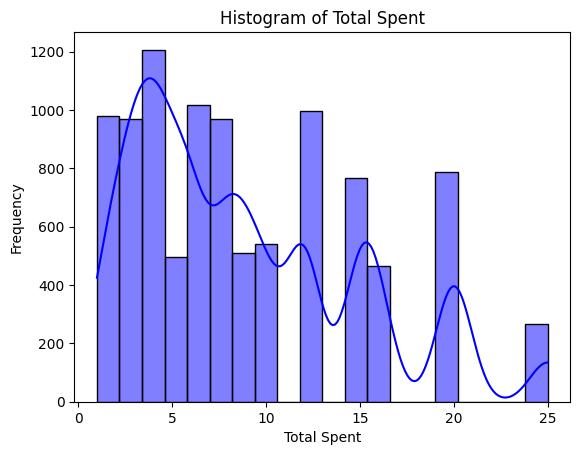

In [28]:
sns.histplot(df['Total Spent'], bins=20, kde=True, color='blue')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.title('Histogram of Total Spent')
plt.show()

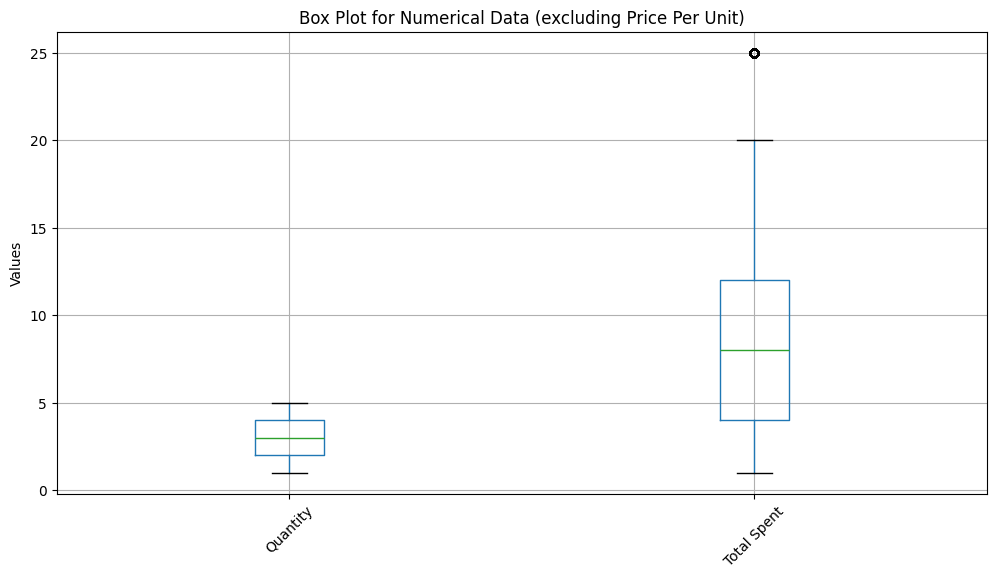

In [30]:

numerical_columns = df.select_dtypes(include=['float64']).drop(columns=['Price Per Unit'])


plt.figure(figsize=(12, 6))
numerical_columns.boxplot()
plt.title('Box Plot for Numerical Data (excluding Price Per Unit)')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [31]:
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# List of numerical columns to check for outliers
numerical_columns = ['Quantity', 'Price Per Unit', 'Total Spent']

# Remove outliers from the dataframe
df = remove_outliers_iqr(df, numerical_columns)

df.shape

(9706, 6)

# Categorical data


## Number of transactions per month

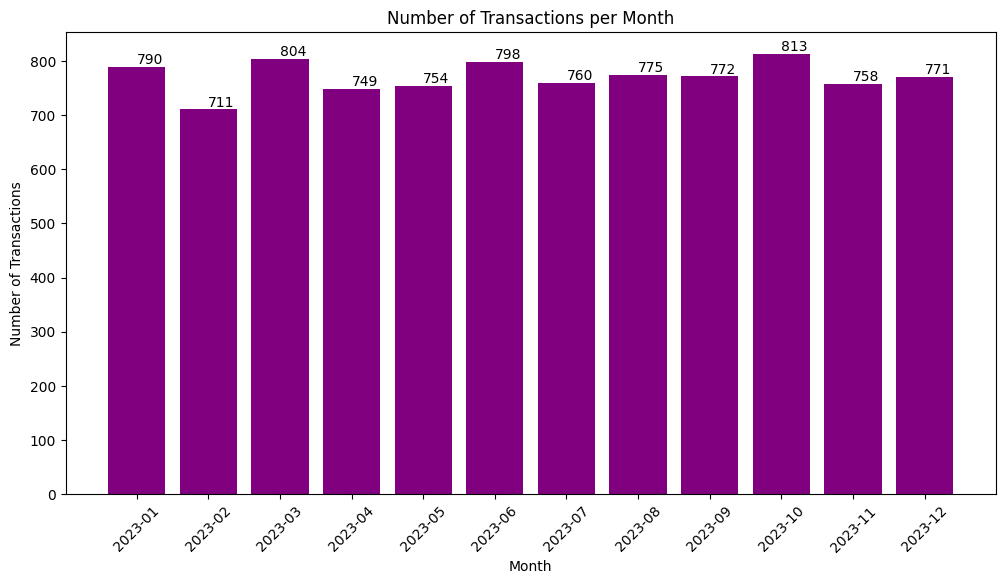

In [32]:
# Extract month and year from the 'Transaction Date' column
df['Month'] = df['Transaction Date'].dt.to_period('M')

# Count the number of transactions per month
monthly_transactions = df['Month'].value_counts().sort_index()

# Plot the number of transactions per month
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_transactions.index.astype(str), monthly_transactions.values, color='purple')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Month')
plt.xticks(rotation=45)
plt.show()

## Bivariate Analysis For the given data


# Numerical - Numerical


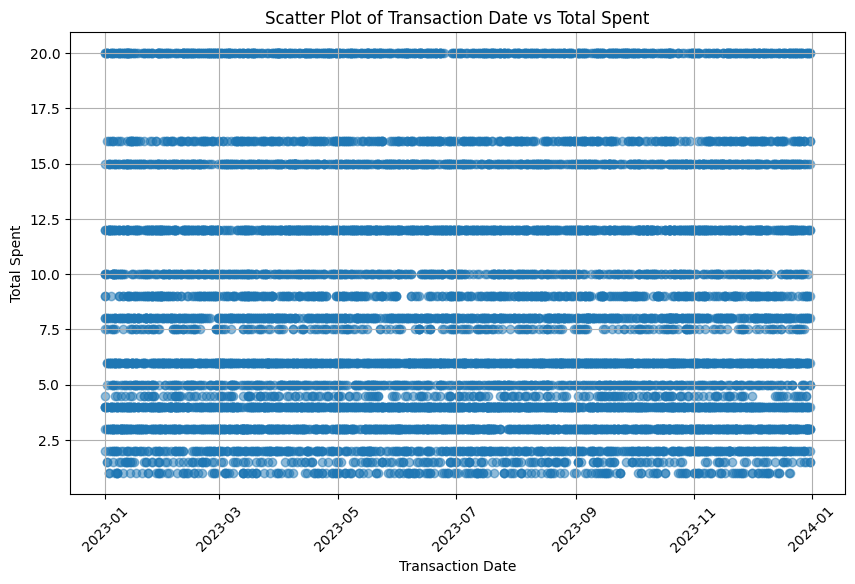

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Transaction Date'], df['Total Spent'], alpha=0.5)
plt.xlabel('Transaction Date')
plt.ylabel('Total Spent')
plt.title('Scatter Plot of Transaction Date vs Total Spent')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

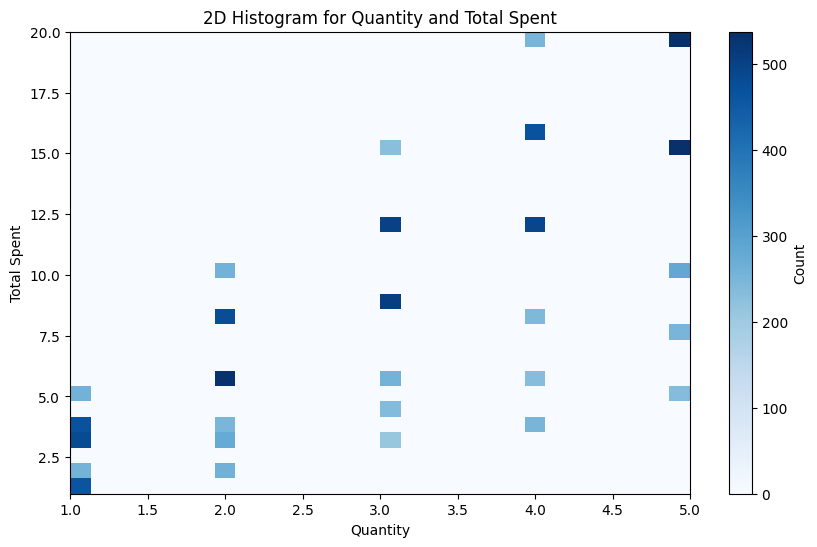

In [35]:
plt.figure(figsize=(10, 6))
plt.hist2d(df['Quantity'], df['Total Spent'], bins=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('Quantity')
plt.ylabel('Total Spent')
plt.title('2D Histogram for Quantity and Total Spent')
plt.show()



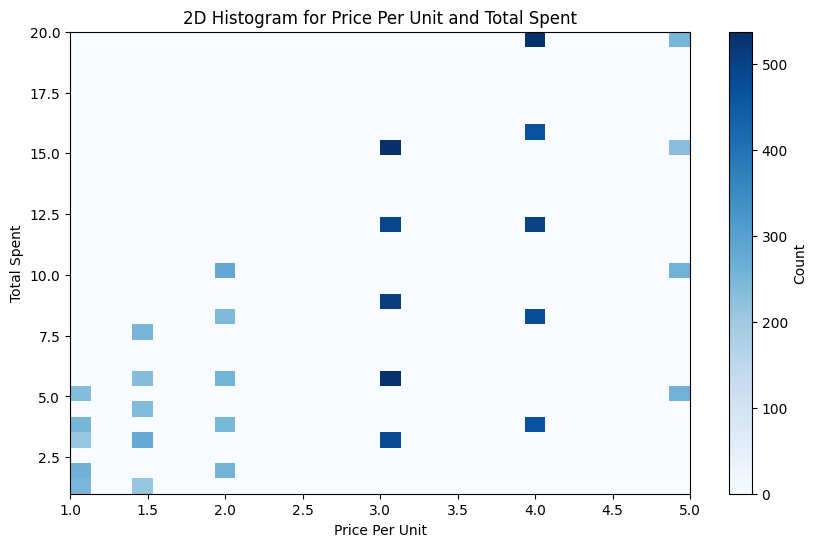

In [38]:
plt.figure(figsize=(10, 6))
plt.hist2d(df['Price Per Unit'], df['Total Spent'], bins=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('Price Per Unit')
plt.ylabel('Total Spent')
plt.title('2D Histogram for Price Per Unit and Total Spent')
plt.show()

## Categorical - Numeriacal

<ipython-input-39-056acc21cae3>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Item', y='Quantity', data=df, ax=axes[1], palette='muted')
<ipython-input-39-056acc21cae3>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Item', y='Quantity', data=df, ax=axes[2], palette='muted')


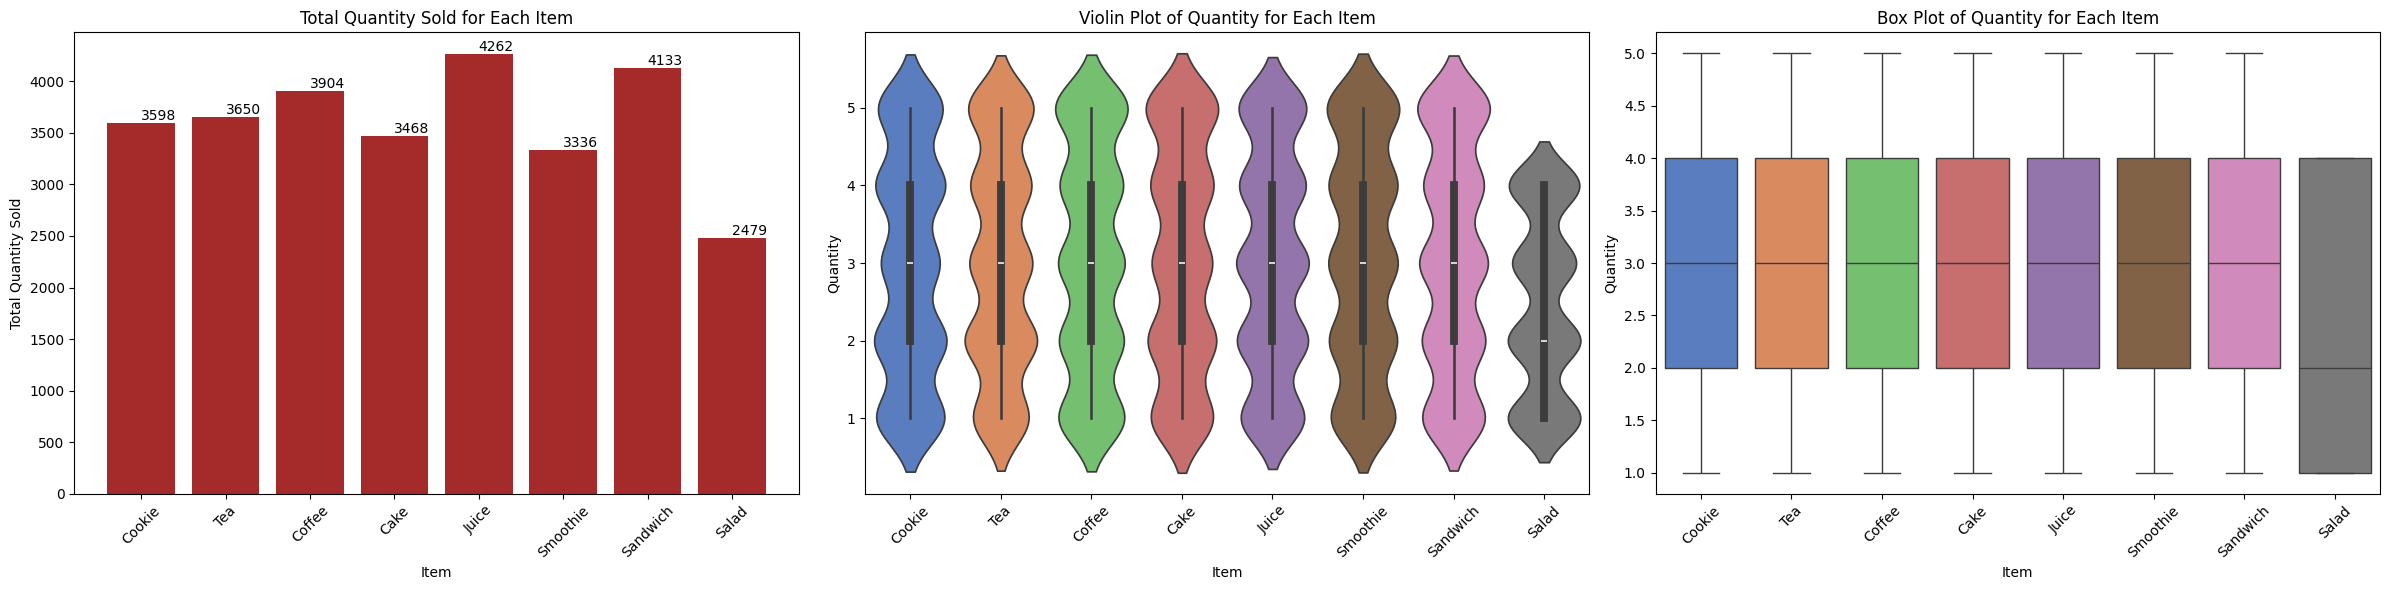

In [39]:
quantity_sold = df.groupby('Item')['Quantity'].sum().reindex(item_price_dict.keys(), fill_value=0)
quantity_sold_dict = quantity_sold.to_dict()

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Bar plot
axes[0].bar(quantity_sold_dict.keys(), quantity_sold_dict.values(), color='brown')
axes[0].set_xlabel('Item')
axes[0].set_ylabel('Total Quantity Sold')
axes[0].set_title('Total Quantity Sold for Each Item')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on top of the bars
for bar in axes[0].patches:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Violin plot
sns.violinplot(x='Item', y='Quantity', data=df, ax=axes[1], palette='muted')
axes[1].set_xlabel('Item')
axes[1].set_ylabel('Quantity')
axes[1].set_title('Violin Plot of Quantity for Each Item')
axes[1].tick_params(axis='x', rotation=45)

# Box plot
sns.boxplot(x='Item', y='Quantity', data=df, ax=axes[2], palette='muted')
axes[2].set_xlabel('Item')
axes[2].set_ylabel('Quantity')
axes[2].set_title('Box Plot of Quantity for Each Item')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-40-a69d8a8e65ae>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Item', y='Total Spent', data=df, ax=axes[1], palette='muted')
<ipython-input-40-a69d8a8e65ae>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Item', y='Total Spent', data=df, ax=axes[2], palette='muted')


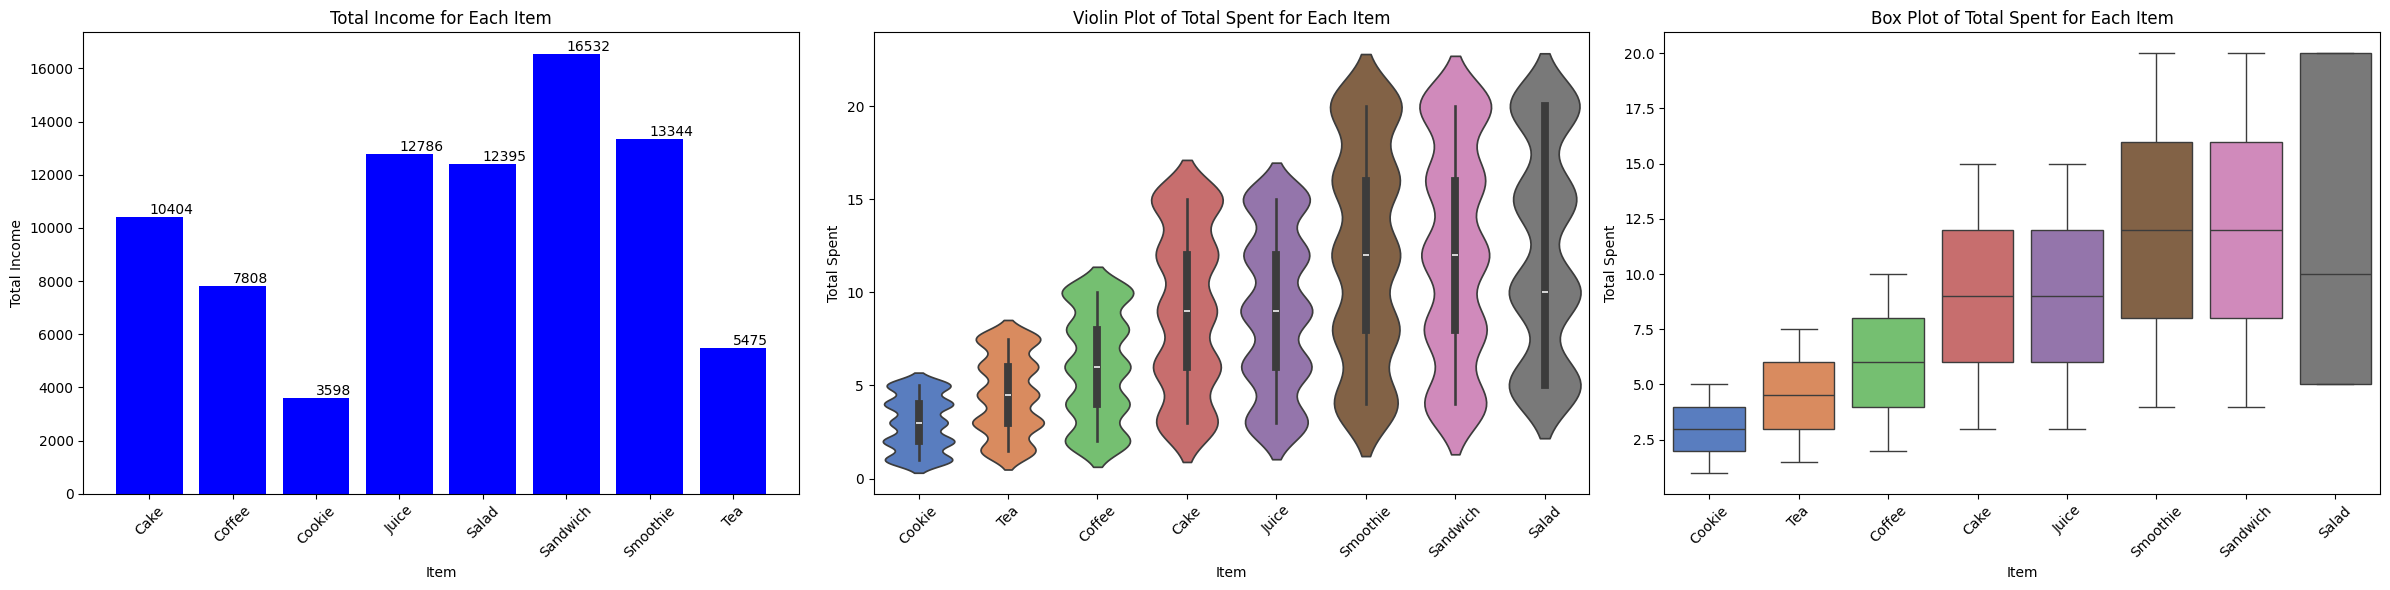

In [40]:
# Calculate the total income for each item
total_income_per_item = df.groupby('Item')['Total Spent'].sum()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Bar plot
bars = axes[0].bar(total_income_per_item.index, total_income_per_item.values, color='blue')
axes[0].set_xlabel('Item')
axes[0].set_ylabel('Total Income')
axes[0].set_title('Total Income for Each Item')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Violin plot
sns.violinplot(x='Item', y='Total Spent', data=df, ax=axes[1], palette='muted')
axes[1].set_xlabel('Item')
axes[1].set_ylabel('Total Spent')
axes[1].set_title('Violin Plot of Total Spent for Each Item')
axes[1].tick_params(axis='x', rotation=45)

# Box plot
sns.boxplot(x='Item', y='Total Spent', data=df, ax=axes[2], palette='muted')
axes[2].set_xlabel('Item')
axes[2].set_ylabel('Total Spent')
axes[2].set_title('Box Plot of Total Spent for Each Item')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-41-ac208106501c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='Quantity', data=df, ax=axes[1], palette='muted')
<ipython-input-41-ac208106501c>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='Quantity', data=df, ax=axes[2], palette='muted')


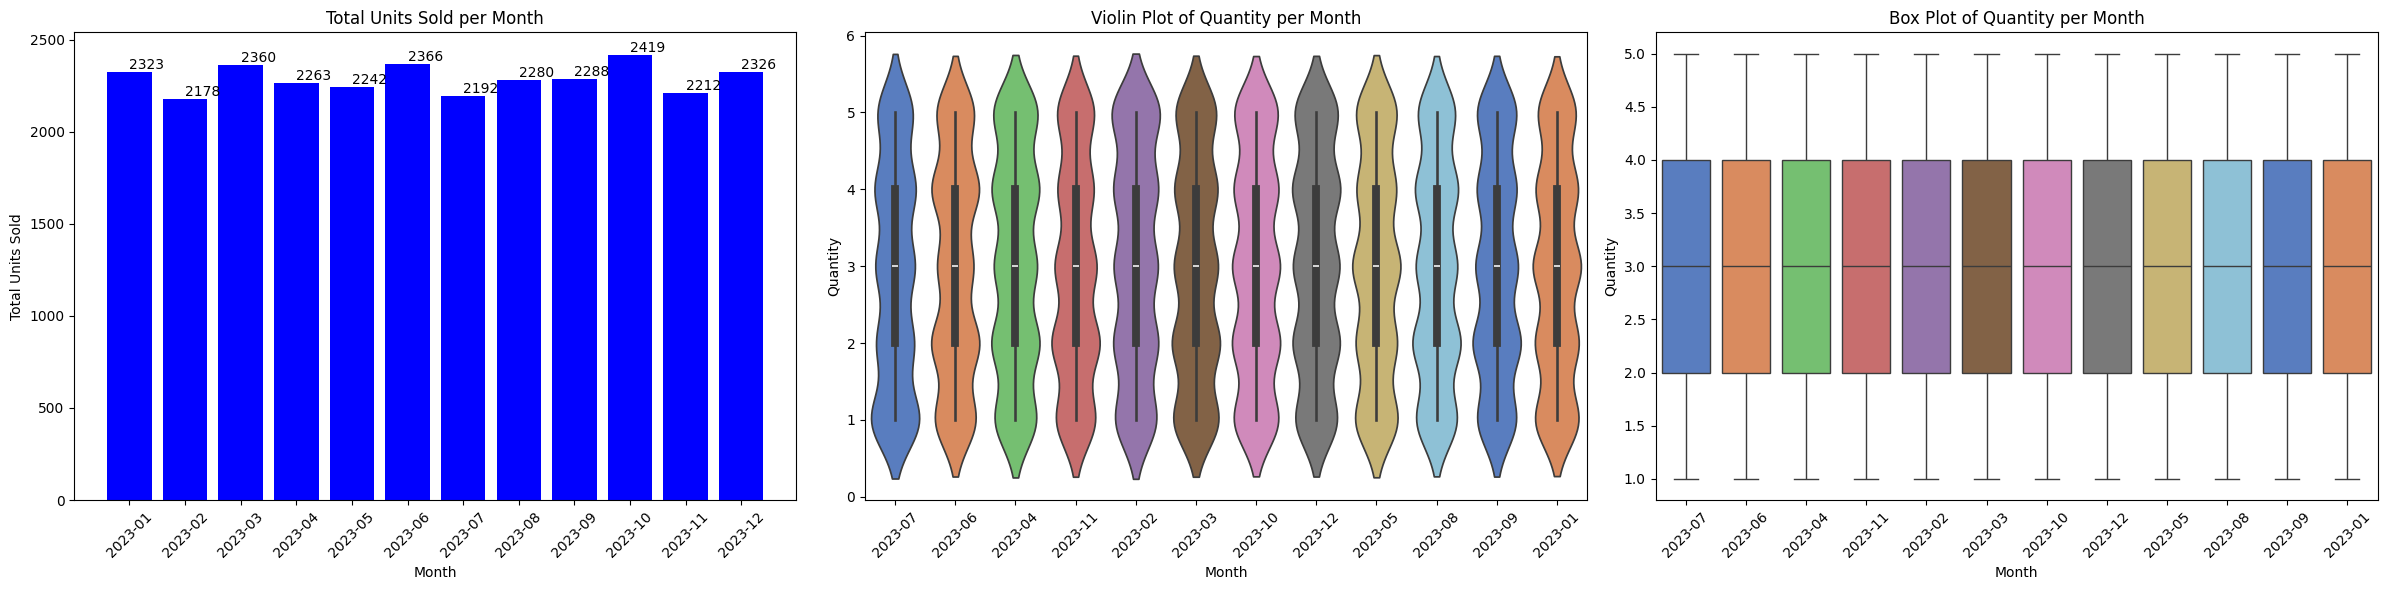

In [41]:
# Group by 'Month' and sum the 'Quantity' for each month
monthly_sales = df.groupby('Month')['Quantity'].sum()

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Bar plot
bars = axes[0].bar(monthly_sales.index.astype(str), monthly_sales.values, color='b', label='Total Units Sold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Units Sold')
axes[0].set_title('Total Units Sold per Month')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Violin plot
sns.violinplot(x='Month', y='Quantity', data=df, ax=axes[1], palette='muted')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Quantity')
axes[1].set_title('Violin Plot of Quantity per Month')
axes[1].tick_params(axis='x', rotation=45)

# Box plot
sns.boxplot(x='Month', y='Quantity', data=df, ax=axes[2], palette='muted')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Quantity')
axes[2].set_title('Box Plot of Quantity per Month')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




<ipython-input-42-102b9c31bd64>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='Total Spent', data=df, ax=axes[1], palette='muted')
<ipython-input-42-102b9c31bd64>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='Total Spent', data=df, ax=axes[2], palette='muted')


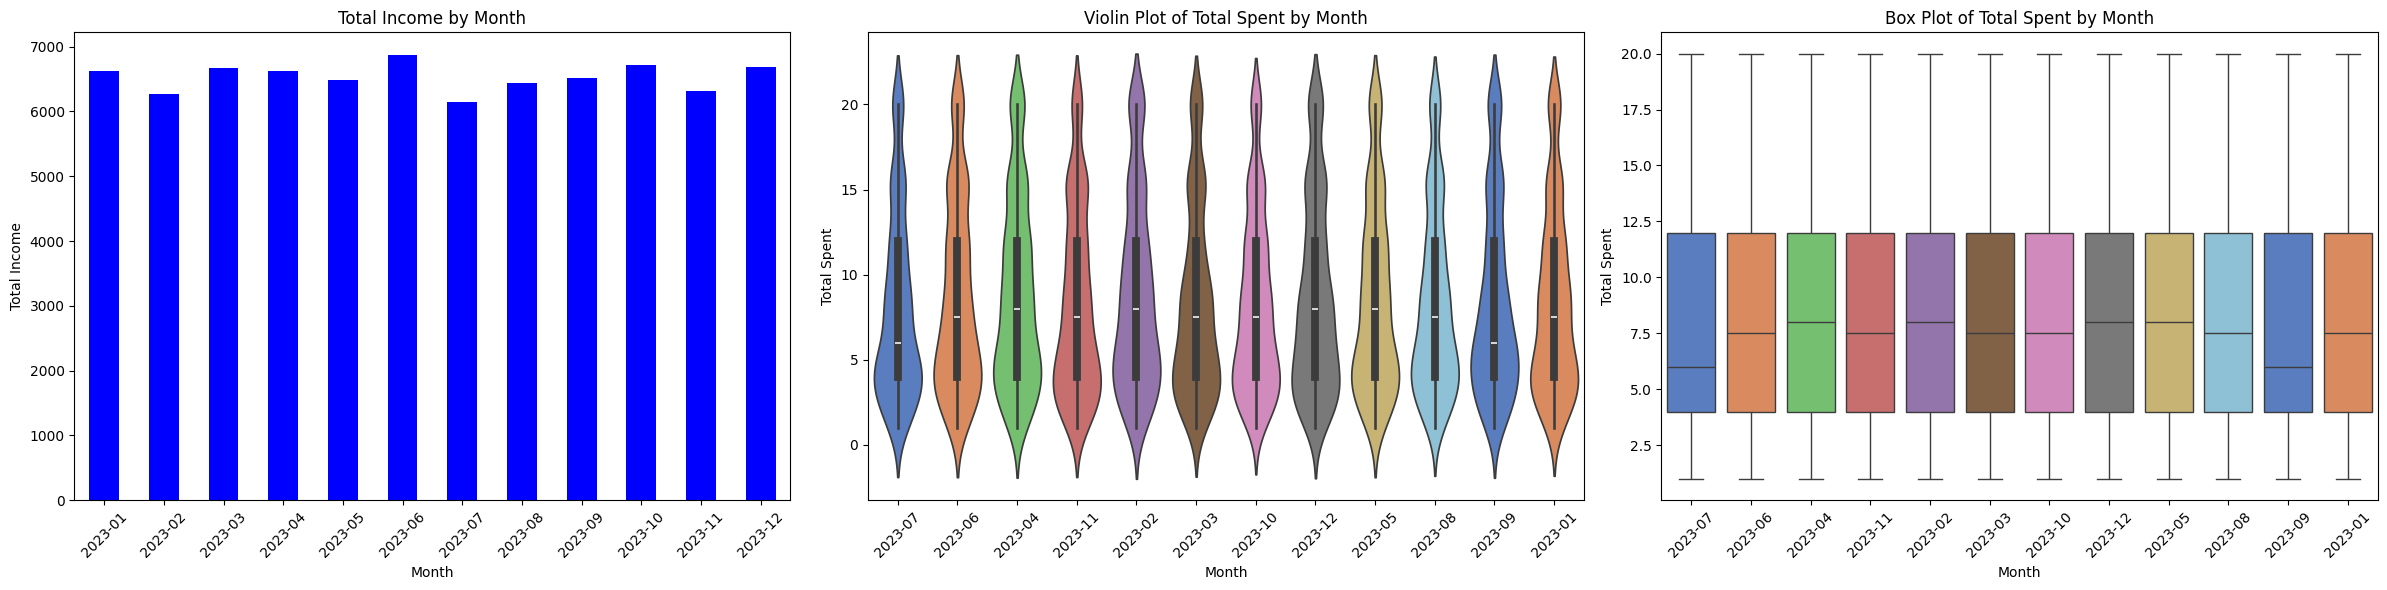

In [42]:
# Group by 'Month' and sum the 'Total Spent' for each month
monthly_income = df.groupby('Month')['Total Spent'].sum()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Bar plot
monthly_income.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Income')
axes[0].set_title('Total Income by Month')
axes[0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(x='Month', y='Total Spent', data=df, ax=axes[1], palette='muted')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Spent')
axes[1].set_title('Violin Plot of Total Spent by Month')
axes[1].tick_params(axis='x', rotation=45)

# Box plot
sns.boxplot(x='Month', y='Total Spent', data=df, ax=axes[2], palette='muted')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Total Spent')
axes[2].set_title('Box Plot of Total Spent by Month')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Multivariate Analysis

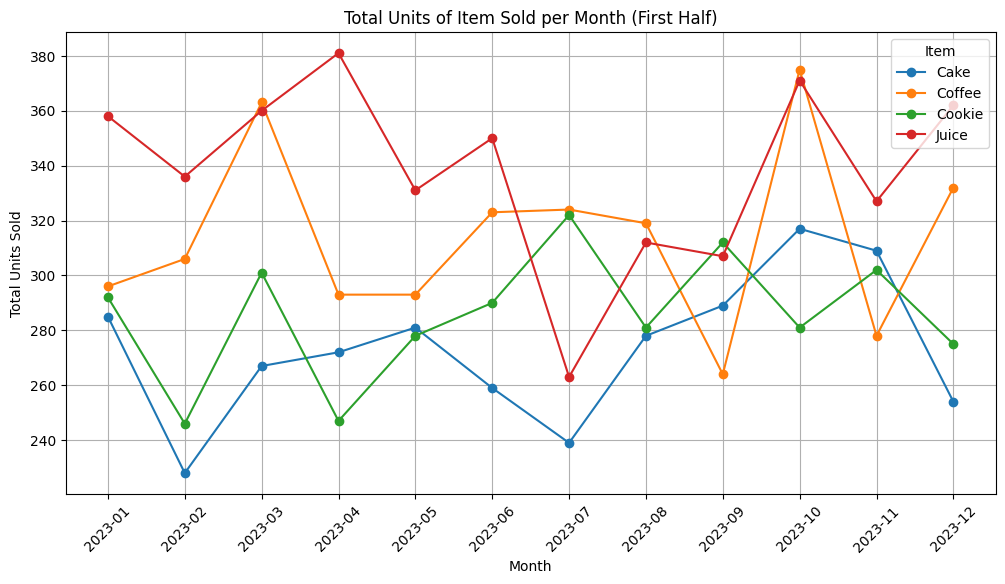

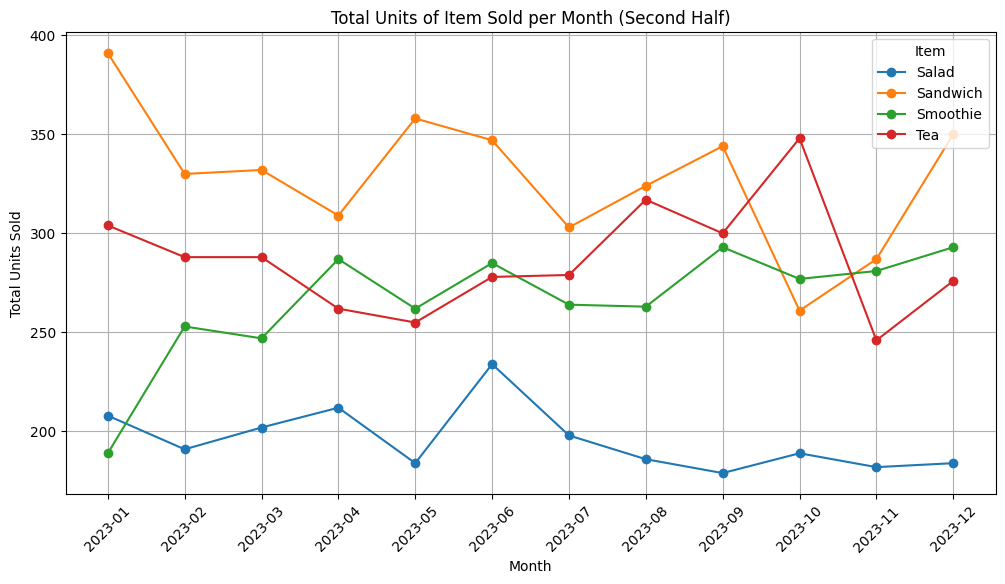

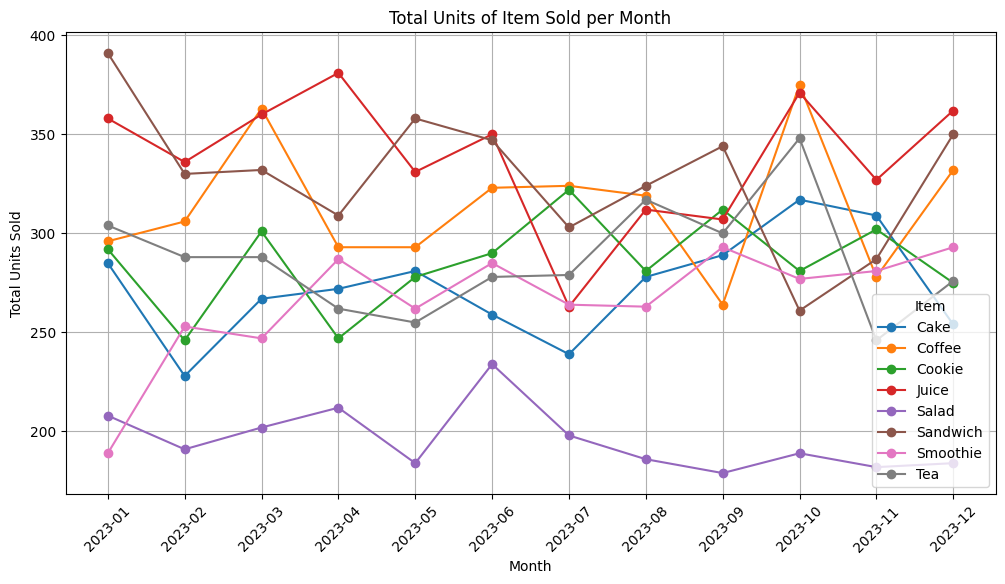

In [43]:
# Group by 'Month' and 'Item' and sum the 'Quantity' for each combination
monthly_item_sales = df.groupby(['Month', 'Item'])['Quantity'].sum().unstack()

# Plot the total units of item sold per month
plt.figure(figsize=(12, 6))

# Plot the first half of the items
for item in monthly_item_sales.columns[:len(monthly_item_sales.columns)//2]:
    plt.plot(monthly_item_sales.index.astype(str), monthly_item_sales[item], marker='o', label=item)

plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.title('Total Units of Item Sold per Month (First Half)')
plt.xticks(rotation=45)
plt.legend(title='Item')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

# Plot the second half of the items
for item in monthly_item_sales.columns[len(monthly_item_sales.columns)//2:]:
    plt.plot(monthly_item_sales.index.astype(str), monthly_item_sales[item], marker='o', label=item)

plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.title('Total Units of Item Sold per Month (Second Half)')
plt.xticks(rotation=45)
plt.legend(title='Item')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

for item in monthly_item_sales.columns:
    plt.plot(monthly_item_sales.index.astype(str), monthly_item_sales[item], marker='o', label=item)

plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.title('Total Units of Item Sold per Month')
plt.xticks(rotation=45)
plt.legend(title='Item')
plt.grid(True)
plt.show()

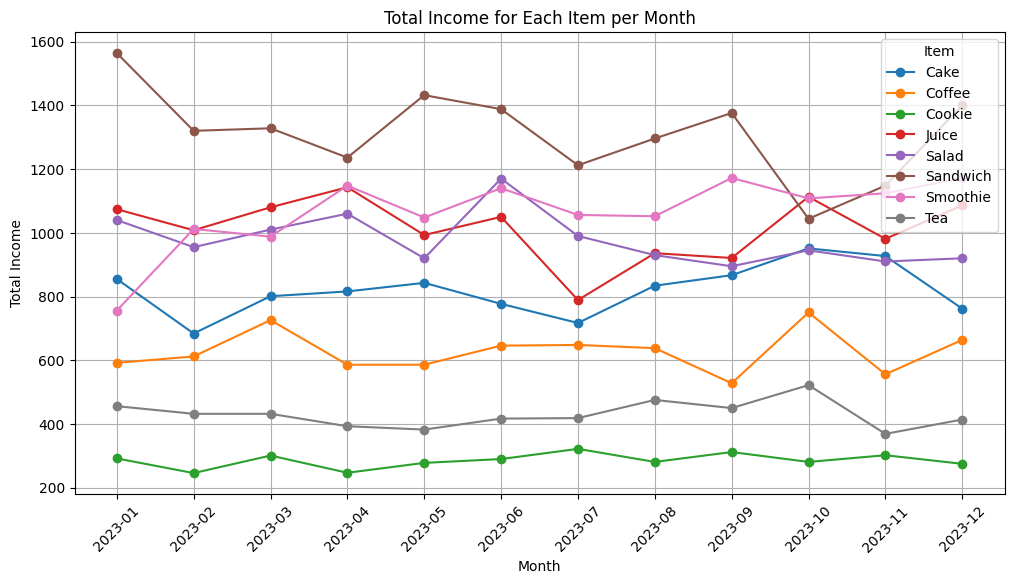

In [44]:
# Group by 'Month' and 'Item' and sum the 'Total Spent' for each combination
monthly_income_per_item = df.groupby(['Month', 'Item'])['Total Spent'].sum().unstack()

# Plot the total income for each item per month
plt.figure(figsize=(12, 6))

# Plot each item
for item in monthly_income_per_item.columns:
    plt.plot(monthly_income_per_item.index.astype(str), monthly_income_per_item[item], marker='o', label=item)

plt.xlabel('Month')
plt.ylabel('Total Income')
plt.title('Total Income for Each Item per Month')
plt.xticks(rotation=45)
plt.legend(title='Item', loc='upper right')
plt.grid(True)
plt.show()

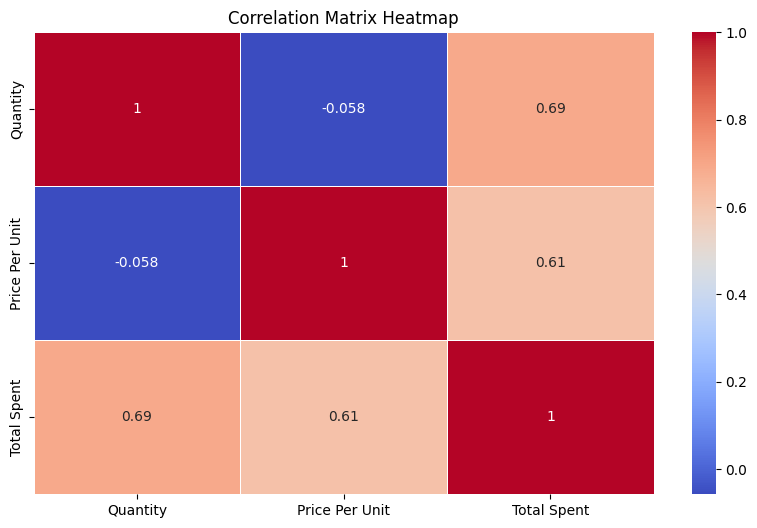

In [45]:
import seaborn as sns

# Calculate the correlation matrix for the selected columns
selected_columns = df[['Quantity', 'Price Per Unit', 'Total Spent']]  # You can modify this list to include any columns you want
correlation_matrix = selected_columns.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()